In [1]:
import os

# Set the path to the folder containing images
folder_path = "car_panorama"

# Get all image files in the folder (sorted)
image_extensions = ('.bmp')
images = sorted([f for f in os.listdir(folder_path) if f.lower().endswith(image_extensions)])

# Rename images from 1 to N
for i, filename in enumerate(images, start=1):
    ext = '.jpg'
    new_name = f"{i}{ext}"  # New name with extension
    old_path = os.path.join(folder_path, filename)
    new_path = os.path.join(folder_path, new_name)
    
    os.rename(old_path, new_path)

print("Renaming complete!")


Renaming complete!


npz file already not exisiting  adobe_panorama/2_1_matches.npz
npz file already not exisiting  adobe_panorama/3_2_matches.npz
npz file already not exisiting  adobe_panorama/4_3_matches.npz
npz file already not exisiting  adobe_panorama/5_4_matches.npz
npz file already not exisiting  adobe_panorama/6_5_matches.npz
npz file already not exisiting  adobe_panorama/7_6_matches.npz
npz file already not exisiting  adobe_panorama/8_7_matches.npz
npz file already not exisiting  adobe_panorama/9_8_matches.npz
npz file already not exisiting  adobe_panorama/10_9_matches.npz
npz file already not exisiting  adobe_panorama/11_10_matches.npz
npz file already not exisiting  adobe_panorama/12_11_matches.npz
npz file already not exisiting  adobe_panorama/13_12_matches.npz
npz file already not exisiting  adobe_panorama/14_13_matches.npz
npz file already not exisiting  adobe_panorama/15_14_matches.npz
npz file already not exisiting  adobe_panorama/16_15_matches.npz
npz file already not exisiting  adobe_pano

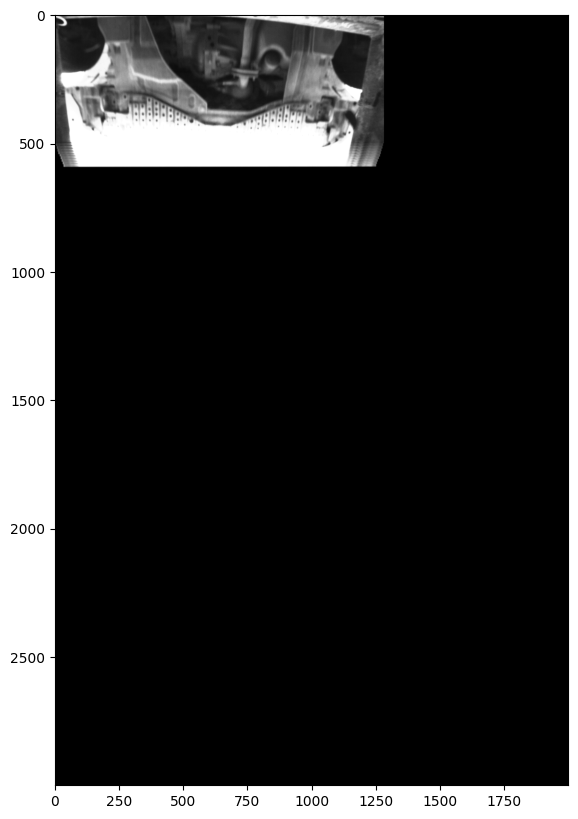

----------------------------------------------------------------------------------------------------


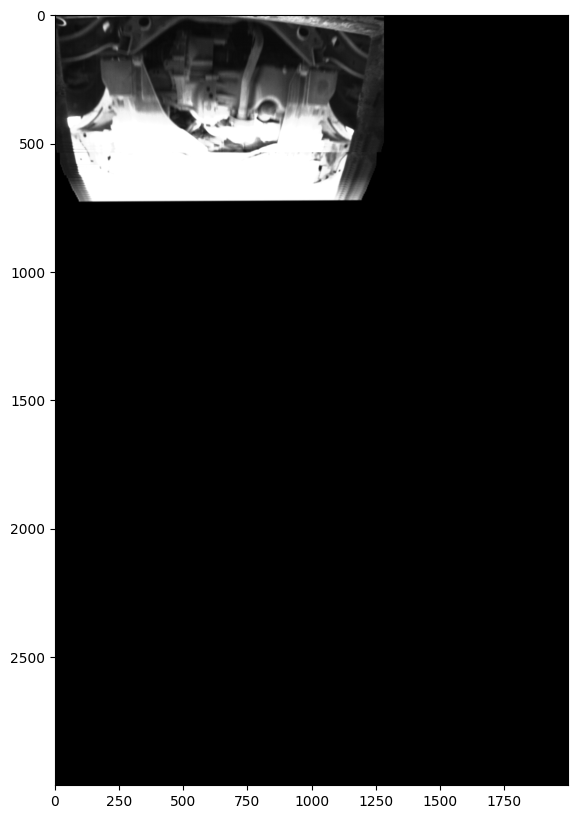

----------------------------------------------------------------------------------------------------


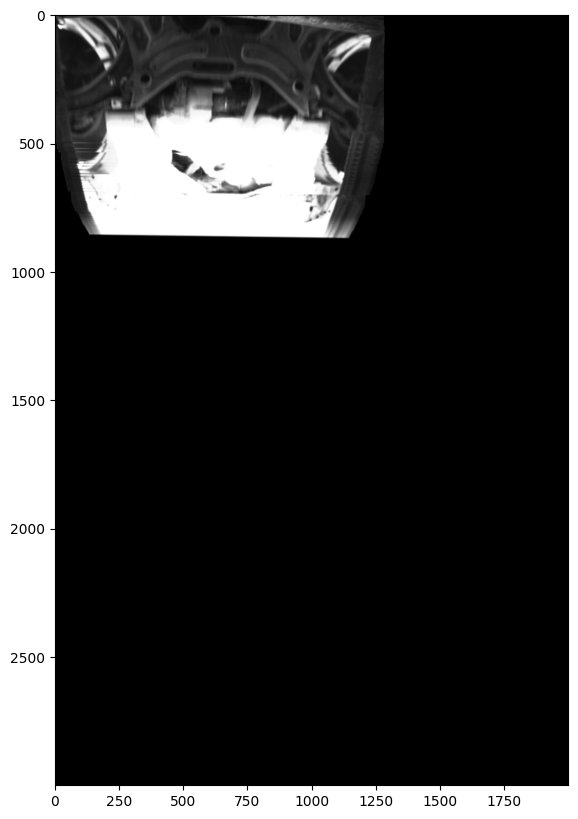

----------------------------------------------------------------------------------------------------


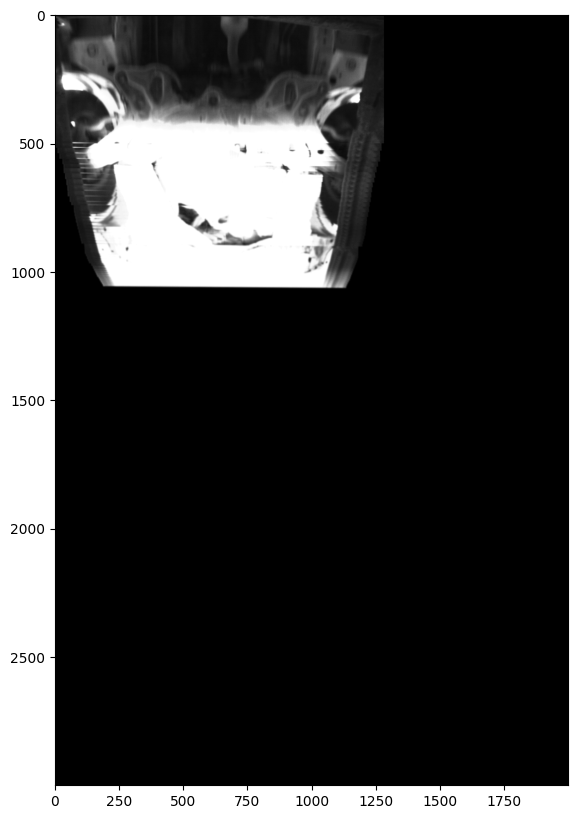

----------------------------------------------------------------------------------------------------


In [2]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import os

# Generating the necessary txt file to input for the SuperGlue algorithm
# Generate the necessary TXT file for SuperGlue
def generate_txt_file(filename, image_pairs,output_directory):
    with open(filename, 'w') as file:
        for pair in image_pairs:
            if not os.path.exists(f"{output_directory}/{pair[1]}_{pair[0]}_matches.npz"):
              print("npz file already not exisiting ", f"adobe_panorama/{pair[1]}_{pair[0]}_matches.npz")  
              file.write(f"{pair[1]}.jpg {pair[0]}.jpg\n")


import subprocess

def run_superglue(input_dir, output_dir, txt_filename='adobe_panorama.txt'):
    command = [
        "python", "match_pairs.py",
        "--resize", "-1",
        "--superglue", "outdoor",
        "--max_keypoints", "2048",
        "--nms_radius", "5",
        "--resize_float",
        "--input_dir", input_dir,
        "--input_pairs", txt_filename,
        "--output_dir", output_dir,
        "--viz",
        "--keypoint_threshold", "0.05",
        "--match_threshold", "0.9"
    ]
    
    try:
        # Running the command
        subprocess.run(command, check=True)
        print("SuperGlue executed successfully!")
        
    except subprocess.CalledProcessError as e:
        print(f"Error occurred: {e}")


def load_npz(npz_file, output_dir):    
    npz = np.load(f'{output_dir}/{npz_file}')
    point_set1 = npz['keypoints0'][npz['matches'] > -1]
    matching_indexes = npz['matches'][npz['matches'] > -1]  
    point_set2 = npz['keypoints1'][matching_indexes]
    return point_set1, point_set2

def plt_source_images(image_set, point_set1, point_set2, input_dir):    
    im_left = cv.imread(f'{input_dir}/{image_set}.jpg', cv.IMREAD_ANYCOLOR)
    im_right = cv.imread(f'{input_dir}/{image_set-1}.jpg', cv.IMREAD_ANYCOLOR)
    
    for point in point_set1.astype(np.int32):
        cv.circle(im_left, tuple(point), radius=8, color=(255, 255, 0), thickness=-1)

    for point in point_set2.astype(np.int32):
        cv.circle(im_right, tuple(point), radius=8, color=(255, 255, 0), thickness=-1)

    fig = plt.figure(figsize=(10, 10))
    plt.subplot(121), plt.imshow(im_left, cmap='gray', vmin=0, vmax=255)
    plt.subplot(122), plt.imshow(im_right, cmap='gray', vmin=0, vmax=255)
    plt.show()

def stitch_images(start_img, end_img, input_dir, output_dir, result_dir):
    npz_files = [f"{i}_{i-1}_matches.npz" for i in range(start_img + 1, end_img + 1)]
    stitched_image = cv.imread(f'{input_dir}/{start_img}.jpg', cv.IMREAD_ANYCOLOR)
    
    for img_set in range(start_img + 1, end_img + 1):  
        point_set1, point_set2 = load_npz(npz_files[img_set - start_img - 1], output_dir)
        # plt_source_images(img_set, point_set1, point_set2, input_dir)
        
        im_left = cv.imread(f'{input_dir}/{img_set}.jpg', cv.IMREAD_ANYCOLOR)
        im_right = stitched_image
        
        H, status = cv.findHomography(point_set1, point_set2, cv.RANSAC, 5.0)
        
        panorama = cv.warpPerspective(im_right, np.linalg.inv(H), (2000, 3000))
        panorama[0:im_left.shape[0], 0:im_left.shape[1]] = im_left
        
        stitched_image = panorama
        
        if img_set%10==0:
            plt.figure(figsize=(10, 10))
            plt.imshow(panorama, cmap='gray', vmin=0, vmax=255)
            plt.show()    
            print("-" * 100)
    
    cv.imwrite(f'{result_dir}/final_result.jpg', stitched_image)

if __name__ == "__main__":
    # Define key parameters for easy modifications
    start_index = 1
    end_index = 48
    input_directory = 'car_panorama/'
    output_directory = 'car_panorama/output'
    result_directory = 'car_panorama/results'
    txt_filename = 'adobe_panorama.txt'

    # Run the functions with defined parameters
    # Run the functions with defined parameters
    first_half_pairs = [(i-1, i) for i in range(2, 49)]
    generate_txt_file(txt_filename,first_half_pairs,output_directory)
    run_superglue(input_directory, output_directory, txt_filename)
    
    stitch_images(start_index, end_index, input_directory, output_directory, result_directory)
